<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week6/GRU-Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional


In [4]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Load data
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json'
response = requests.get(url)

if response.status_code == 200:
    try:
        # Try to read as newline-delimited JSON
        df = pd.read_json(url, lines=True)
    except ValueError:
        # If that fails, try to read as a list of dictionaries
        data = json.loads(response.text)
        df = pd.DataFrame(data)
else:
    print("Failed to download data, check URL or internet connection.")

print("Data shape:", df.shape)
print("\nSample data:")
print(df.head())


Data shape: (26709, 3)

Sample data:
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [6]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())



Missing values:
article_link    0
headline        0
is_sarcastic    0
dtype: int64


In [7]:
# Basic statistics
print("\nClass distribution:")
print(df['is_sarcastic'].value_counts())



Class distribution:
is_sarcastic
0    14985
1    11724
Name: count, dtype: int64


In [8]:
# Preprocess data
X = df['headline'].values
y = df['is_sarcastic'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [9]:
# Tokenize the text
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [10]:
# Define model builder for hyperparameter tuning
def build_model(hp):
    model = Sequential()

    # Embedding layer
    embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=32)
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

    # GRU layers
    gru_units = hp.Int('gru_units', min_value=32, max_value=128, step=32)
    bidirectional = hp.Boolean('bidirectional')

    if bidirectional:
        model.add(Bidirectional(GRU(units=gru_units, return_sequences=True)))
        model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Bidirectional(GRU(units=gru_units)))
    else:
        model.add(GRU(units=gru_units, return_sequences=True))
        model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(GRU(units=gru_units))

    # Output layer
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [11]:
# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # You can increase this for better results
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='sarcasm_detection'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [12]:
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [13]:
# Search for the best hyperparameters
tuner.search(
    X_train_pad,
    y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Trial 5 Complete [00h 00m 28s]
val_accuracy: 0.5547496676445007

Best val_accuracy So Far: 0.8544688820838928
Total elapsed time: 00h 02m 28s


In [14]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters:")
print(f"Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"GRU Units: {best_hps.get('gru_units')}")
print(f"Bidirectional: {best_hps.get('bidirectional')}")
print(f"Dropout 1: {best_hps.get('dropout_1')}")
print(f"Dropout 2: {best_hps.get('dropout_2')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")



Best Hyperparameters:
Embedding Dimension: 64
GRU Units: 32
Bidirectional: True
Dropout 1: 0.4
Dropout 2: 0.5
Learning Rate: 0.00011667547945716362


In [15]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)


In [16]:
# Train the model
history = best_model.fit(
    X_train_pad,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5419 - loss: 0.6865 - val_accuracy: 0.5629 - val_loss: 0.6519
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7119 - loss: 0.5464 - val_accuracy: 0.8393 - val_loss: 0.3657
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8763 - loss: 0.3062 - val_accuracy: 0.8554 - val_loss: 0.3419
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9151 - loss: 0.2274 - val_accuracy: 0.8521 - val_loss: 0.3597
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9396 - loss: 0.1781 - val_accuracy: 0.8498 - val_loss: 0.4038
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9569 - loss: 0.1380 - val_accuracy: 0.8482 - val_loss: 0.4621


In [18]:
# Evaluate the model
y_pred_prob = best_model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")



167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Evaluation Metrics:
Accuracy: 0.8413
Precision: 0.8343
Recall: 0.7966
F1 Score: 0.8150
AUC: 0.9257


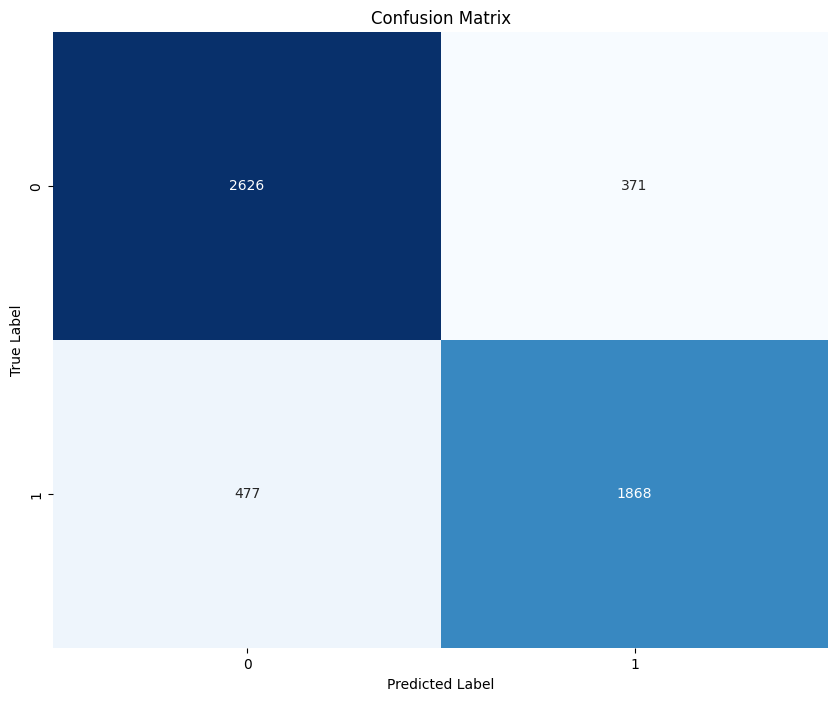

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

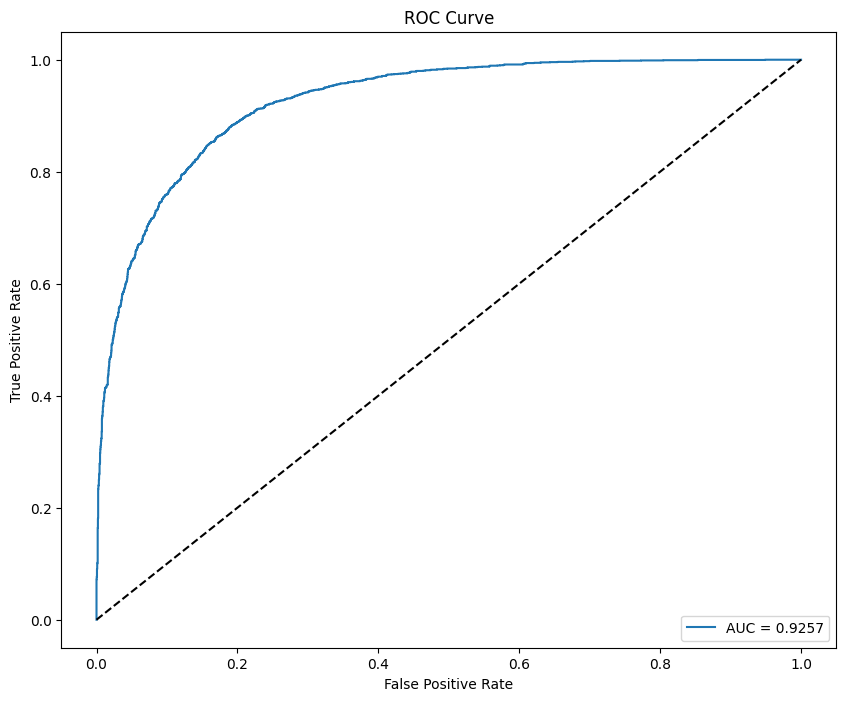

In [21]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

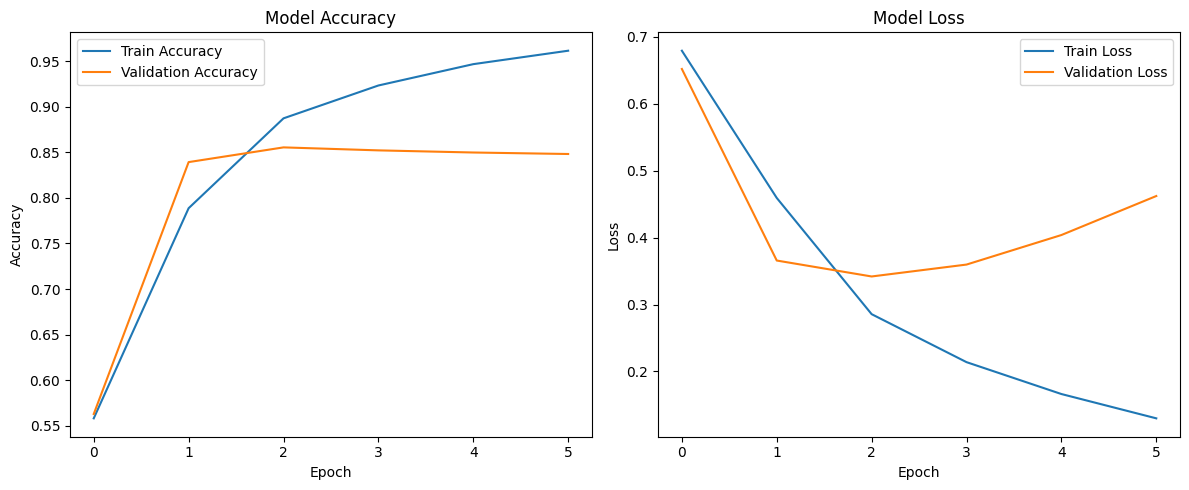

In [22]:
# Training & Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Optional: Save the model
best_model.save('sarcasm_detection_gru_model.h5')


In [24]:
# Example prediction function
def predict_sarcasm(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    prediction = best_model.predict(padded)[0][0]
    result = "Sarcastic" if prediction > 0.5 else "Not Sarcastic"
    return f"Text: '{text}'\nPrediction: {result} (Confidence: {prediction:.4f})"


In [25]:
# Example usage
examples = [
    "Local man loses life savings in bitcoin crash",
    "New study shows that drinking water is good for your health",
    "Area man considered interesting by co-workers"
]

print("\nPrediction Examples:")
for example in examples:
    print(predict_sarcasm(example))
    print("-" * 50)


Prediction Examples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Text: 'Local man loses life savings in bitcoin crash'
Prediction: Sarcastic (Confidence: 0.9846)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Text: 'New study shows that drinking water is good for your health'
Prediction: Not Sarcastic (Confidence: 0.2140)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Text: 'Area man considered interesting by co-workers'
Prediction: Sarcastic (Confidence: 0.9885)
--------------------------------------------------
